In [0]:
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.engine.topology import get_source_inputs

### Data Import and Exploration

In [11]:
fileId = '14FiaZImlYMupUbX19utXgSq-ajy2df3'

import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted zip file ' + fileName)

#image_files=os.listdir('images')
#=[x.split('.')[0] for x in image_files]
#with open('annotations/trainval.txt', 'w') as text_file:
#  for row in im_files:
#    text_file.write(row + '\n')

Extracted zip file 14FiaZImlYMupUbX19utXgSq-ajy2dfZ3.zip


### Model

In [19]:
from keras.preprocessing import image
from keras.applications import resnet50, inception_v3, vgg16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras.optimizers import Adam
import numpy as np

batch_size = 64
num_classes = 2

base_model = resnet50.ResNet50
#base_model = inception_v3.InceptionV3
#base_model = vgg16.VGG16

base_model = base_model(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(300, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [ ]:
t=0
for layer in base_model.layers:
  if t<5:
    t=t+1
    continue
  layer.trainable = False

In [20]:
from keras import models, regularizers, layers, optimizers, losses, metrics
model.compile(optimizer=optimizers.Adam(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("model compiled")
print(model.summary())

model compiled
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
_____________________________________________________________________________

In [13]:
pwd

'/content'

In [7]:
PATHtrain ='/content/data'
p = PATHtrain+'/train'
q = PATHtrain+'/validation'
print(len(os.listdir(PATHtrain)))
Labels = os.listdir(q)

2


### Creation of additional data using Keras ImageDataGenerator

In [17]:
from keras.preprocessing.image import ImageDataGenerator
train_dir = p
validation_dir = q
#test_dir = PATHtest
batch_size = 32
target_size=(224, 224)

#train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,target_size=target_size,batch_size=batch_size)
validation_generator = test_datagen.flow_from_directory(
    validation_dir,target_size=target_size,batch_size=batch_size)
#test_generator = test_datagen.flow_from_directory(
#    test_dir,target_size=target_size,batch_size=batch_size)

Found 75 images belonging to 2 classes.
Found 7 images belonging to 2 classes.


### Model fitting

In [21]:
 history = model.fit_generator(train_generator,
                              epochs=50,
                              steps_per_epoch = 10682 // batch_size,
                              validation_data = train_generator,
                              validation_steps = 3562 // batch_size)

Epoch 1/50
166/166 [==============================] - 117s 706ms/step - loss: 0.6218 - acc: 0.6821 - val_loss: 0.4710 - val_acc: 0.8082
Epoch 2/50
166/166 [==============================] - 109s 659ms/step - loss: 0.3671 - acc: 0.8724 - val_loss: 0.3390 - val_acc: 0.8821
Epoch 3/50
166/166 [==============================] - 110s 661ms/step - loss: 0.2615 - acc: 0.9264 - val_loss: 0.2777 - val_acc: 0.9008
Epoch 4/50
166/166 [==============================] - 114s 684ms/step - loss: 0.1913 - acc: 0.9559 - val_loss: 0.2438 - val_acc: 0.9096
Epoch 5/50
166/166 [==============================] - 110s 664ms/step - loss: 0.1613 - acc: 0.9581 - val_loss: 0.1854 - val_acc: 0.9363
Epoch 6/50
166/166 [==============================] - 113s 679ms/step - loss: 0.1360 - acc: 0.9652 - val_loss: 0.1859 - val_acc: 0.9273
Epoch 7/50
166/166 [==============================] - 112s 676ms/step - loss: 0.1176 - acc: 0.9731 - val_loss: 0.1930 - val_acc: 0.9153
Epoch 8/50
166/166 [============================

### Plotting Training and validation accuracy and losses

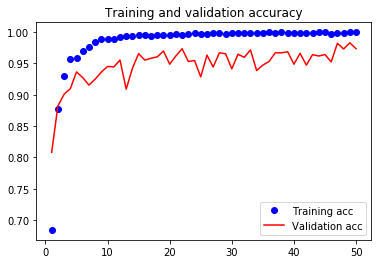

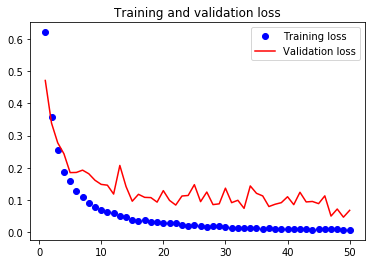

In [24]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [25]:
# saving model
model.save('No_ballResNet50FineTune_1.h5')
print("No_ballResNet50FineTune.h5 was saved")

No_ballResNet50FineTune.h5 was saved


In [0]:
print(train_generator.class_indices)
print(validation_generator.class_indices)